In [89]:
# Module imports

import database.connect
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [90]:
# Connect to SQL database

connection=database.connect.getConnection()
cursor=connection.cursor(buffered=True)

In [91]:
categories = {'booking': ['booking', 'booked', 'book', 'ticket', 'tickets'],
            'canceling': ['canceled', 'cancellations'],
            'money': ['refund', 'compensation', 'claim', 'money', 'pay', 'paid'],
            'baggage': ['bag', 'baggage', 'luggage', 'bags'],
            'staff': ['staff', 'crew'],
            'waiting': ['waiting', 'delay', 'wait'],
            'boarding': ['boarding'],
            'stuck': ['stuck'],

            'information': ['info', 'information'],
            'customers': ['customer', 'customers', 'passenger', 'passengers'],
            'dm': [' dm'], 
            }

airlines_dict = {'KLM': ['klm'],
                'AirFrance':['airfrance',
                            'air france'],
                'British_Airways': ['british_airways',
                                    'british airways'],
                'AmericanAir': ['americanair',
                                'american airlines'],
                'Lufthansa': ['lufthansa'],
                'AirBerlin': ['airberlin',
                                'air berlin'],
                'AirBerlin assist': ['airberlin assist',
                                    'air berlin assist',
                                    'airberlinassist'],
                'easyJet': ['easyjet'],
                'RyanAir': ['ryanair'],
                'SingaporeAir': ['singaporeair',
                                'singapore airlines'],
                'Qantas': ['qantas'],
                'EtihadAirways': ['etihad airways',
                                'etihadairways',
                                'etihad'],
                'VirginAtlantic': ['virgin atlantic',
                                    'virginatlantic'],
            }

airlines_of_interest = ['AmericanAir', 'Other', 'British_Airways']

In [92]:
def avg_resp_time():

    # Function takes in an airline and returns the mean sentiment

    Query= (f"""
                SELECT part_of.cID, AVG(tweets.reply_time) 
                FROM tweets, part_of, conversations 
                WHERE tweets.id = part_of.tID AND part_of.cID = conversations.id AND conversations.Airline <> '0' 
                GROUP BY conversations.id
                """)
    execute=cursor.execute(Query)
    result=cursor.fetchall()
    df1 = pd.DataFrame(result)
    df1.columns = ['cID','reply_time']
    df1 = df1.set_index('cID')
    return df1

# TODO
def init_sent():

    # Find the median sentiment per airline
    try:
        Query = (f"""
                SELECT conversations.id, sentiment, conversations.Length
                FROM conversations , part_of ,tweets
                WHERE conversations.ID = part_of.cID AND tweets.id=part_of.tID AND Position = 1 and conversations.Airline <>'0';

                 """)
        execute = cursor.execute(Query)
        result = cursor.fetchall()
        df2 = pd.DataFrame(result)
        df2.columns = ['cID','init_sentiment','Length']
        df2 = df2.set_index('cID')
        return df2

    except:
        print("Error")
        return 0.00


def sent_change():

    # Find the median sentiment per airline
    try:
        Query = (f"""
                 SELECT bs1.cID, CASE
	            WHEN (bs1.sentiment_sum/bs1.tweet_count) > (bs2.sentiment_sum / bs2.tweet_count) THEN -1*ABS((bs1.sentiment_sum / bs1.tweet_count) - (bs2.sentiment_sum / bs2.tweet_count))
                 ELSE ABS((bs1.sentiment_sum / bs1.tweet_count) - (bs2.sentiment_sum / bs2.tweet_count))
                END AS average_sent_diff
                    FROM `binned_sentiment` bs1, `binned_sentiment` bs2, (SELECT cID, MAX(bin_position) AS max_pos FROM `binned_sentiment` GROUP BY cID) AS max_bins WHERE bs1.cID = bs2.cID AND bs1.cID = max_bins.cID AND bs1.bin_position= 1 AND bs2.bin_position=max_pos
                
                    """)
        execute = cursor.execute(Query)
        result = cursor.fetchall()
        df3 = pd.DataFrame(result)
        df3.columns = ['cID','avg_sent_change']
        df3 = df3.set_index('cID')
        return df3

    except:
        print("Error")
        return 0.00

def get_conversation_categories():
    excluided = ['dm', 'customers', 'information']
    relevant_categories = [key for key in categories.keys() if key not in excluided]
    # for each conversation, get weather it incluides a category.
    # returns a dataframe with the conversation id and the categorys
    categories_query = ""

    for category in relevant_categories:
        categories_query += f"(CASE WHEN tweets.{category} != 0 THEN 1 ELSE 0 END) AS {category}, "

    query = (f"""
                SELECT part_of.cID, {categories_query[:-2]}
                FROM tweets, part_of
                WHERE tweets.id = part_of.tID 
                GROUP BY part_of.cID
                """)
    execute = cursor.execute(query)
    result = cursor.fetchall()
    df4 = pd.DataFrame(result)
    df4.columns = ['cID'] + relevant_categories
    # remove the index column
    df4 = df4.set_index('cID')
    return df4
             

In [93]:
df_avg_resp_time=avg_resp_time()
df_sent_change=sent_change()
df_init_sent=init_sent()
df_convo_cat=get_conversation_categories()

In [94]:
# Join the data frames on the shared index 'cID'
joined_df = pd.merge(df_avg_resp_time, df_sent_change, on='cID')
joined_df = pd.merge(joined_df, df_init_sent, on='cID')
joined_df = pd.merge(joined_df, df_convo_cat, on='cID')
joined_df=joined_df.apply(pd.to_numeric, errors='coerce')
# Print the joined data frame
print(joined_df)

           reply_time  avg_sent_change  init_sentiment  Length  booking  \
cID                                                                       
890      8.983450e+05          0.40000        0.383205       2        0   
896      6.679164e+06          0.16667       -0.756792       2        1   
968      5.301991e+07          0.31667       -0.625706       2        0   
978      3.534351e+07          0.60000       -0.846166       3        0   
1641     1.003128e+08          0.40000       -0.556714       2        0   
...               ...              ...             ...     ...      ...   
1030527  1.956224e+06          0.00000        0.939009       2        0   
1030546  7.650142e+06          1.20000       -0.825245       4        1   
1030601  8.227027e+07          0.00000       -0.770683       5        0   
1030607  1.728335e+05          0.70000       -0.869712       4        0   
1030616  1.565545e+05          0.50000        0.031116       4        0   

         canceling  mone

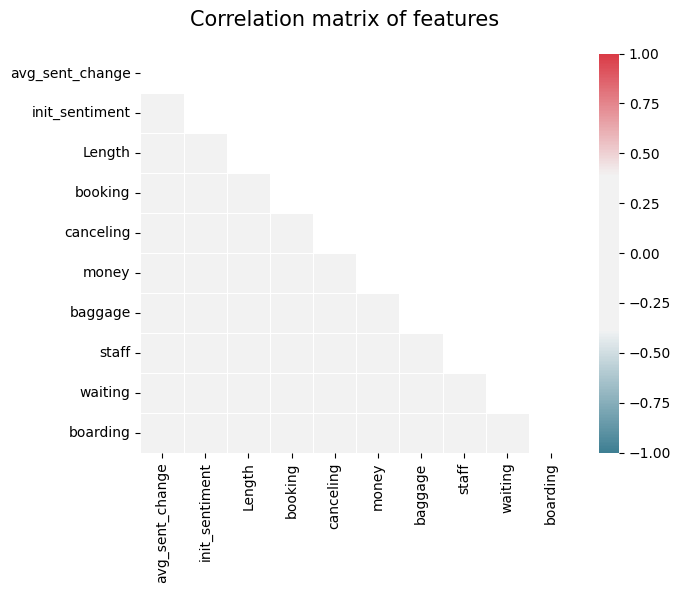

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




def corr_matrix():
    df =joined_df

    df = df.iloc[:, 1:-1]

    corr = df.corr(method='spearman')

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(7, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

    fig.suptitle('Correlation matrix of features', fontsize=15)


    fig.tight_layout()

corr_matrix()

In [96]:
from sklearn import linear_model
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
def multiple_regress():
    df = joined_df

    #substitue for actual feature names later
    features = ['reply_time', 'init_sentiment', 'Length', 'booking','canceling','money','baggage','staff','waiting','boarding','stuck']
    target = 'avg_sent_change'

    X = df[features].values.reshape(-1, len(features))
    y = df[target].values

    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)

    #model.coef_

    print('Features                :  %s' % features)
    print('Regression Coefficients : ', [round(item, 7) for item in model.coef_])
    print('R-squared               :  %.2f' % model.score(X, y))
    print('Y-intercept             :  %.2f' % model.intercept_)
    print('')
multiple_regress()


Features                :  ['reply_time', 'init_sentiment', 'Length', 'booking', 'canceling', 'money', 'baggage', 'staff', 'waiting', 'boarding', 'stuck']
Regression Coefficients :  [-0.0, -0.0016827, -0.0025622, 0.0062593, -0.0087856, 0.0223433, -0.0222029, -0.0349941, -0.0403511, -0.0221575, 0.0430495]
R-squared               :  0.00
Y-intercept             :  0.19



In [97]:
df_avg_resp_time
features = ['reply_time', 'init_sentiment', 'Length', 'booking','canceling','money','baggage','staff','waiting','boarding','stuck']
joined_df[features].values.reshape(-1, len(features))
joined_df['avg_sent_change']

cID
890        0.40000
896        0.16667
968        0.31667
978        0.60000
1641       0.40000
            ...   
1030527    0.00000
1030546    1.20000
1030601    0.00000
1030607    0.70000
1030616    0.50000
Name: avg_sent_change, Length: 20079, dtype: float64

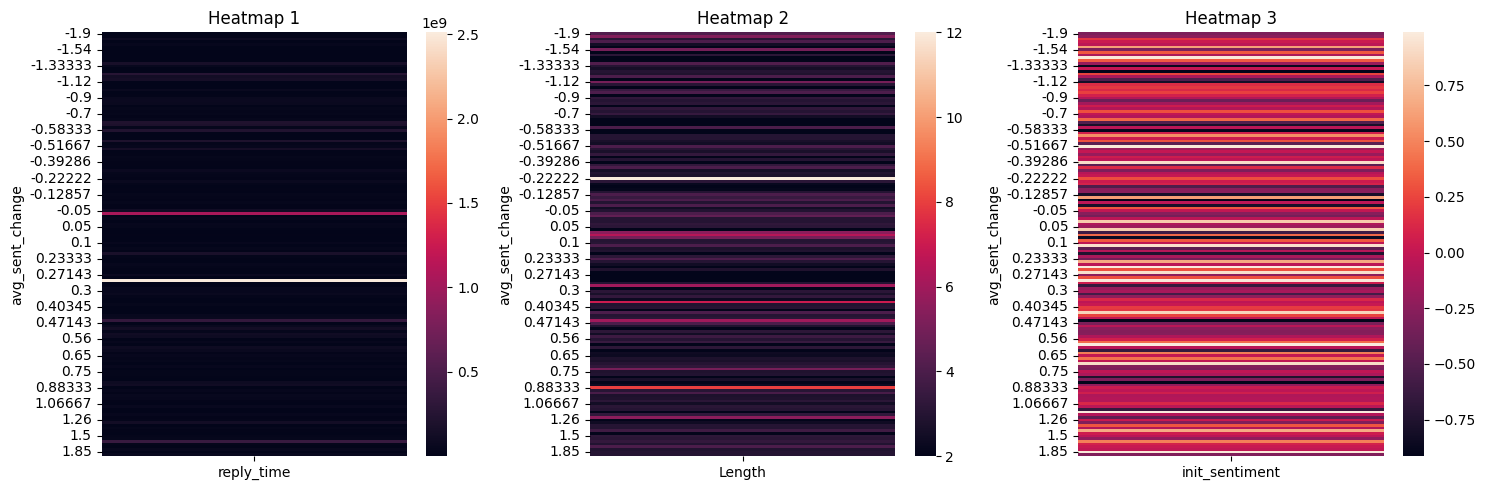

In [98]:
x=test_df.loc[:,['avg_sent_change','reply_time', 'init_sentiment', 'Length']]
x = x.apply(pd.to_numeric, errors='coerce')
x=df = x.reset_index(drop=True)
x= x.pivot_table(index='avg_sent_change')

# Assuming you have three heatmaps: heatmap1, heatmap2, and heatmap3

# Create a figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot the first heatmap
sns.heatmap(x.loc[:,['reply_time']], ax=axes[0])
axes[0].set_title('Heatmap 1')

# Plot the second heatmap
sns.heatmap(x.loc[:,[ 'Length']], ax=axes[1])
axes[1].set_title('Heatmap 2')

# Plot the third heatmap
sns.heatmap(x.loc[:,['init_sentiment']], ax=axes[2])
axes[2].set_title('Heatmap 3')

# Adjust the layout and spacing
plt.tight_layout()

# Show the plot
plt.show()





